- 2021.06.09  u.k.  porting to new spectra
- 2021.06.17  u.k.  reporducibility confirmed
- 2021.07.06  u.k.  heat map of transition matrix

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


C:\Users\lelou\AppData\Local\Temp\ipykernel_38632\3391910190.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np

#%matplotlib inline
#%matplotlib qt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


In [3]:
%load_ext autoreload
%autoreload 2

from spectra_src.ImportAll import *
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', DeprecationWarning)

In [4]:
from spectra_src.Struct import Atom, Atmosphere, Radiation
from spectra_src.Atomic import Collision, SEsolver, ContinuumOpacity
from spectra_src.Util import HelpUtil
from spectra_src.Visual import Plotting#, Grotrian
from spectra_src.Atomic import LTELib
from spectra_src.Function.SEquil import SELib
from spectra_src.Atomic import Hydrogen

In [3]:
# comment out for porting from (old) spectra to spectra
# import sys
# sys.path.append("../../")
# 
# %load_ext autoreload
# %autoreload 2
# 
# from src.Structure import AtomCls, AtmosphereCls
# from src.Atomic import Collision, SEsolver, Opacity
# from src.Util import Class
# from src.Visual import Grotrian, Plotting
# from src.Atomic import LTELib
# from src.Function.StatisticalEquilibrium import LibSpatialVectorized as SELib
# from src.Atomic import Hydrogen
# 
# import src.Constants as Cst
# import src.Config as Cfg


---


In [5]:
import os

conf_path = os.path.join( CFG._ROOT_DIR, "data/conf/Ca_II.conf" )
atom, wMesh, path_dict = Atom.init_Atom_(conf_path , is_hydrogen=False)

In [20]:
HelpUtil.help_( wMesh )

------------------------------------------------------------------------------------------
name                       type                                 value/len/shape
------------------------------------------------------------------------------------------
Wavelength_Mesh
|- Cont_mesh               ndarray                              s: (5, 41)
|- Cont_Coe                struct array                         s: (5,)
  |-  idxI                 int64                                s: (5,)
  |-  idxJ                 int64                                s: (5,)
  |-  w0                   float64                              s: (5,)
  |-  nLambda              int64                                s: (5,)
|- Line_mesh               ndarray                              s: (860,)
|- Line_mesh_idxs          ndarray                              s: (10, 2)
|- Line_absorb_prof        ndarray                              s: (860,)
|- Line_Coe                struct array                         

In [11]:
#
# atom, _ = AtomCls.InitAtom(f"{Cfg.ROOT_DIR_}/data/conf/Ca_II.conf", isHydrogen=False)

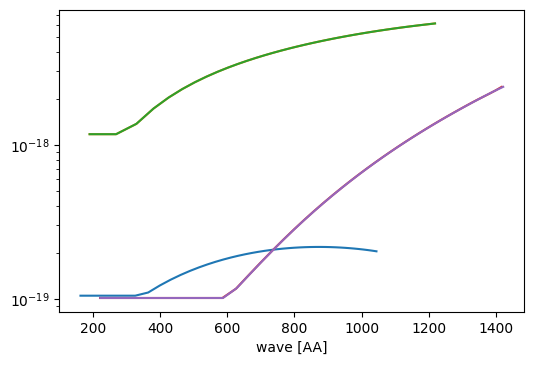

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=100)
for k in range(5):
    ax.plot(wMesh.Cont_mesh[k,:]*1E8, atom.PI.alpha_interp[k,:])
    ax.set_yscale("log")
    ax.set_xlabel("wave [AA]")
plt.show()

In [5]:
#atom, _ = AtomCls.InitAtom(f"{Cfg.ROOT_DIR_}/data/conf/H.conf", isHydrogen=True)
import os 

conf_path = os.path.join( CFG._ROOT_DIR, "data/conf/H.conf" )
atom, wMesh, path_dict = Atom.init_Atom_(conf_path , is_hydrogen=True)

#conf_path = os.path.join( CFG._ROOT_DIR, "data/conf/Ca_II.conf" )
#atom, wMesh, path_dict = Atom.init_Atom_(conf_path , is_hydrogen=False)

atmos = Atmosphere.Atmosphere0D(Nh=1.E12, Ne=1.E11, Te=7.E3, Vd=0., Vt=5.E5)
radiation = Radiation.init_Radiation_(atmos, wMesh)

In [21]:
#slab0d = AtmosphereCls.AtmosphereC0d()
#slab0d.read_BackRad_QS()
#backRad = slab0d.BackRad
#backRad.shape

(2, 4158162)

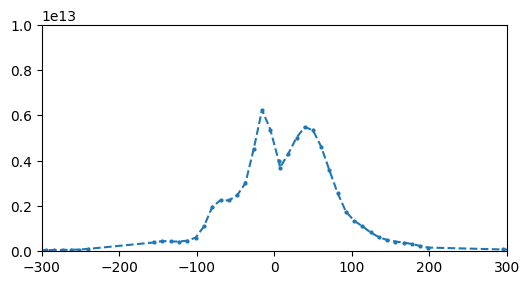

In [40]:
w0_ = 1215.6  # [AA]

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=100)
ax.plot((radiation.backRad[0,:]*1E8-w0_)/w0_*CST.c_*1E-5, radiation.backRad[1,:], '--o', markersize=2)

ax.set_xlim(-300, +300)
ax.set_ylim(0,0.1E14)
plt.show()

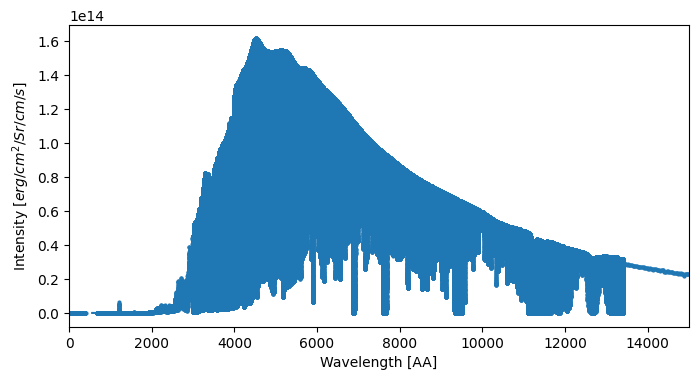

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=100)
ax.plot(radiation.backRad[0,:]*1E8, radiation.backRad[1,:], '--o', markersize=2)
ax.set_xlim(0, 15000)
ax.set_xlabel("Wavelength [AA]")
ax.set_ylabel("Intensity [$erg/cm^2/Sr/cm/s$]")
plt.show()

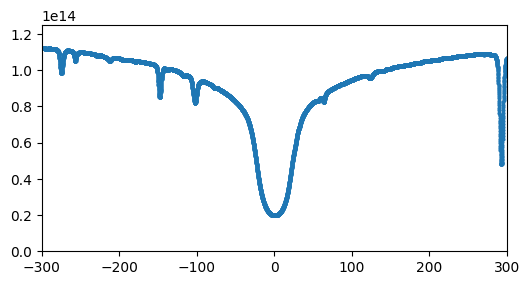

In [33]:
w0_ = 6564.6  # [AA]

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=100)
ax.plot((radiation.backRad[0,:]*1E8-w0_)/w0_*CST.c_*1E-5, radiation.backRad[1,:], '--o', markersize=2)

ax.set_xlim(-300, +300)
ax.set_ylim(0,1.25E14)
plt.show()

---

---


## Einstein `Aji` coeficient

fitting formula form *Johnson1972* v.s. NIST data

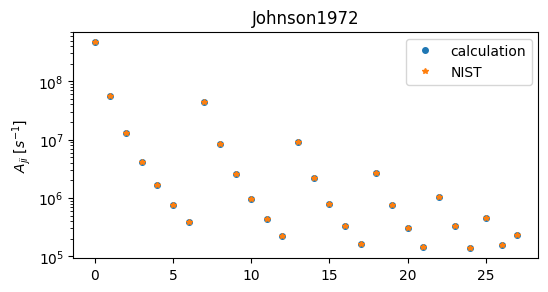

In [10]:
ni_arr = atom.Line["idxI"][:] + 1
nj_arr = atom.Line["idxJ"][:] + 1
Aji = Hydrogen.einstein_A_coefficient_(ni_arr, nj_arr)

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=100)
ax.plot( Aji[:], 'o', markersize=4, label="calculation")
ax.plot( atom.Line["AJI"][:], "*", markersize=4, label="NIST" )

ax.legend(loc="best")
ax.set_yscale("log")
ax.set_title("Johnson1972")
ax.set_ylabel("$A_{ji} \; [s^{-1}]$")
plt.show()


## Collisional Excitation rate coefficient

fitting formula from *Johnson1972*

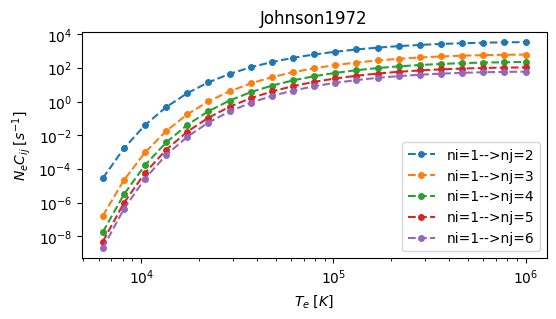

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=100)

n = 21
Te = np.logspace(3.8, 6, n)
Ne = 1E11

k = 6
ni = 1
for nj in range(ni+1, k+1):
    Cij = Hydrogen.CE_rate_coe_(ni,nj,Te)
    ax.plot( Te, Ne*Cij, '--o', markersize=4, label=f"ni={ni}-->nj={nj}" )

ax.legend(loc="best")
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("$T_{e} \; [K]$")

ax.set_title("Johnson1972")
ax.set_ylabel("$N_{e}C_{ij} \; [s^{-1}]$")
plt.show()

## Collisional ionization rate coefficient

fitting formula from *Johnson1972* and *Clark+1991*

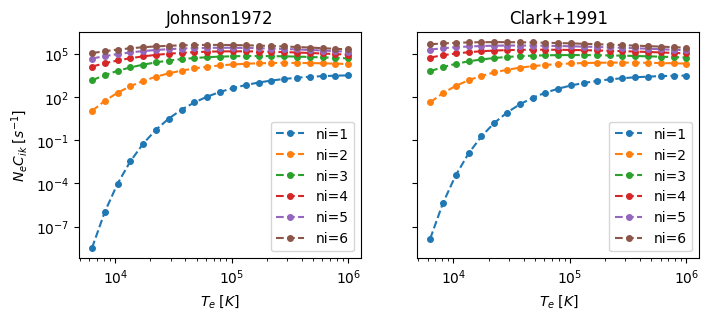

In [12]:
fig, axs = plt.subplots(1,2, figsize=(8,3), dpi=100, sharey=True)

n = 21
Te = np.logspace(3.8, 6, n)
Ne = 1E11

k = 6

functions = {
    "Johnson1972" : Hydrogen.CI_rate_coe_,
    "Clark+1991"  : Hydrogen.CI_rate_coe_clark_,
}

for i, name in enumerate(functions.keys()):
    ax = axs[i]
    for ni in range(1, k+1):
        Cik = functions[name](ni,Te)
        ax.plot( Te, Ne*Cik, '--o', markersize=4, label=f"ni={ni}" )
        ax.legend(loc="best")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(name)
        ax.set_ylabel( "$N_{e}C_{ik} \; [s^{-1}]$" ) if i==0 else None
        ax.set_xlabel( "$T_{e} \; [K]$" )

plt.show()

**let's use *Johnson1972* version**

## bound-free Gaunt factor

fitting formula from *Johnson1972* and *Gingerich+1991*

`Hydrogen.gaunt_factor_gingerich_` wrong ?

in `Hydrogen.gaunt_factor_gingerich_cm_`

```
    w_um = w * 1.E5     # [cm] -> [um] is *1.E4, why 1.E5
    #w_um = w * 1.E4
```

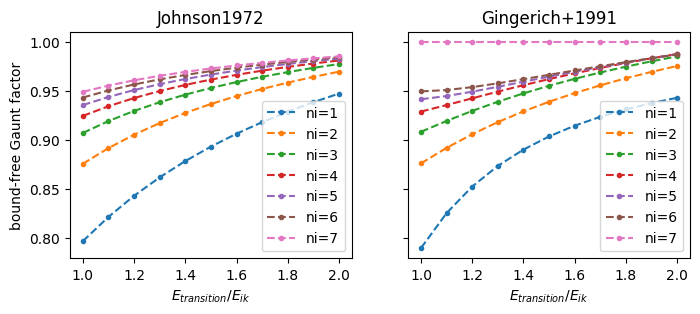

In [15]:
x = np.linspace(1, 2, 11)

fig, axs = plt.subplots(1,2, figsize=(8,3), dpi=100, sharey=True)

functions = {
    "Johnson1972" : Hydrogen.gaunt_factor_,
    "Gingerich+1991"  : Hydrogen.gaunt_factor_gingerich_,
}

for i, name in enumerate(functions.keys()):
    ax = axs[i]
    for ni in range(1,8):
        g = functions[name](ni, x)
        ax.plot( x, g, '--o', markersize=3, label=f"ni={ni}" )
        ax.legend(loc='best')
        ax.set_title(name)
        ax.set_xlabel("$E_{transition}/E_{ik}$")
        ax.set_ylabel("bound-free Gaunt factor") if i==0 else None

#ax.set_ylim(0.7, 1.)
plt.show()

**let's use *Johnson1972* version**

## photoionization cross section

fitting formula from *Johnson1972*

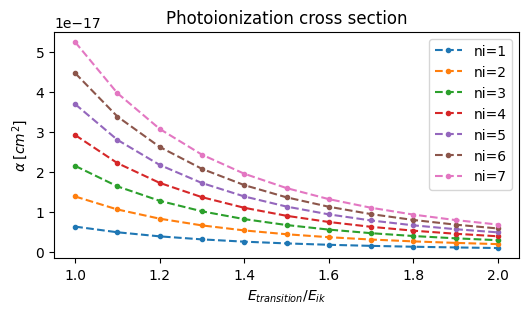

In [16]:
x = np.linspace(1, 2, 11)

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=100)

functions = {
    "Photoionization cross section" : Hydrogen.PI_cross_section_,
}

for i, name in enumerate(functions.keys()):
    for ni in range(1,8):
        alpha = functions[name](ni, x, 1)
        ax.plot( x, alpha, '--o', markersize=3, label=f"ni={ni}" )
        ax.legend(loc='best')
        ax.set_title(name)
        ax.set_ylabel("$\\alpha \; [cm^{2}]$")
        ax.set_xlabel("$E_{transition}/E_{ik}$")


plt.show()

## Spontaneous radiative recombination

fitting formula from *Johnson1972* v.s. integration using the photoionization cross section above

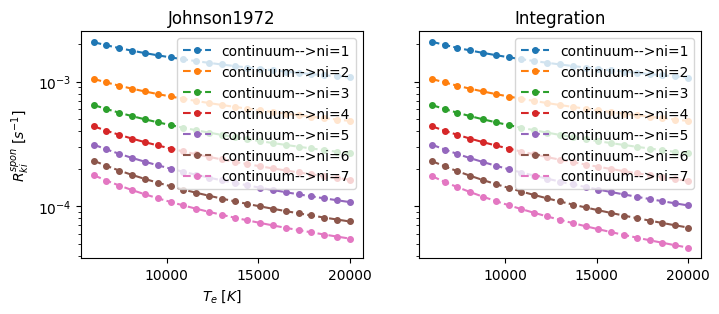

In [17]:
fig, axs = plt.subplots(1,2, figsize=(8,3), dpi=100, sharey=True)

n = 21
#Te = np.logspace(3.8, 6, n)
Te = np.linspace(6000, 2E4, n)
Ne = 1E10

for ni in range(1, 8):
    RCki = Hydrogen.Rki_spon_rate_coe_(ni,Te)
    ax.plot( Te, Ne*RCki, '--o', markersize=4, label=f"continuum-->ni={ni}" )
    ax.legend(loc="best")

Tr = 6E3

Rki_spon_arr = []
for t in range(Te.shape[0]):
    n_LTE , nj_by_ni = SELib._ni_nj_LTE_(atom.Level, atom.Line, atom.Cont, Te[t], Ne)
    nj_by_ni_Cont = nj_by_ni[atom.nLine:]
    Rik, Rki_stim, Rki_spon = SELib._bf_R_rate_(atom.Cont, wMesh.Cont_mesh, Te[t], nj_by_ni_Cont ,              atom.PI.alpha_interp, radiation.PI_intensity, radiation.backRad , Tr, use_Tr=True,    doppler_shift_continuum=False)
    #Rik, Rki_stim, Rki_spon = SELib.bf_R_rate(atom, Te[t], nj_by_ni_Cont, _Tr=Tr)
    Rki_spon_arr.append( Rki_spon )
Rki_spon_arr = np.array( Rki_spon_arr )

ax = axs[1]
for ni in range(1, 8):
    ax.plot( Te, Rki_spon_arr[:,ni-1], '--o', markersize=4, label=f"continuum-->ni={ni}" )
    ax.legend(loc="best")
    ax.set_yscale("log")
    ax.set_title("Integration")


ax = axs[0]
for ni in range(1, 8):
    RCki = Hydrogen.Rki_spon_rate_coe_(ni,Te) # [s^{-1}cm^{3}]
    ax.plot( Te, Ne*RCki, '--o', markersize=4, label=f"continuum-->ni={ni}" )
    ax.legend(loc="best")
    ax.set_yscale("log")
    ax.set_title("Johnson1972")

#ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("$T_{e} \; [K]$")
ax.set_ylabel("$R_{ki}^{spon} \; [s^{-1}]$")
plt.show()

**let's use integration of photoionization cross section**

## Statictical Equilibrium

with $Planck(T_{r})$ as background radiatoin


In [18]:
atmos = Atmosphere.Atmosphere0D(Nh=1.E12, Ne=1.E11, Te=1.E4, Vd=0., Vt=5.E5, Tr=6.E3, use_Tr=True)

SE_con, Rate_con = SELib.cal_SE_with_Ne_Te_(atom, atmos, wMesh,radiation, None)


print(f"Electron temperature  = {atmos.Te:.1E}")
print(f"Electron density      = {atmos.Ne:.1E}")
print(f"Radiation temperature = {atmos.Tr:.1E}")
print('-'*35)
print("SE  :")
for v in SE_con.n_SE[:]:
    print(f"{v:.4E}",end="  ")
print(f"\nLTE :")
for v in SE_con.n_LTE[:]:
    print(f"{v:.4E}",end="  ")


Electron temperature  = 1.0E+04
Electron density      = 1.0E+11
Radiation temperature = 6.0E+03
-----------------------------------
SE  :
9.3761E-01  1.0247E-08  6.0146E-10  2.9739E-10  2.5427E-10  2.6191E-10  2.9356E-10  3.4400E-10  6.2394E-02  
LTE :
2.9534E-04  8.5584E-09  2.1514E-09  1.7761E-09  1.9457E-09  2.3104E-09  2.7994E-09  3.3906E-09  9.9970E-01  

with solar background radiation (data)


In [19]:
atmos = Atmosphere.Atmosphere0D(Nh=1.E12, Ne=1.E11, Te=1.E4, Vd=0., Vt=5.E5, Tr=6.E3, use_Tr=False)
SE_con, Rate_con = SELib.cal_SE_with_Ne_Te_(atom, atmos, wMesh,radiation, None)


print(f"Electron temperature  = {atmos.Te:.1E}")
print(f"Electron density      = {atmos.Ne:.1E}")
print('-'*35)
print("SE  :")
for v in SE_con.n_SE[:]:
    print(f"{v:.4E}",end="  ")
print(f"\nLTE :")
for v in SE_con.n_LTE[:]:
    print(f"{v:.4E}",end="  ")


Electron temperature  = 1.0E+04
Electron density      = 1.0E+11
-----------------------------------
SE  :
7.7996E-01  3.0904E-07  2.8527E-09  1.0432E-09  8.0050E-10  7.5313E-10  7.9961E-10  9.3354E-10  2.2004E-01  
LTE :
2.9534E-04  8.5584E-09  2.1514E-09  1.7761E-09  1.9457E-09  2.3104E-09  2.7994E-09  3.3906E-09  9.9970E-01  

## Ionization fraction v.s. Electron temperature


In [21]:
nTe = 51
Te = np.linspace(3E3, 2E4, nTe)

Ne = np.ones(nTe) * 1E13
Vd = np.ones(nTe) * 0E5 # [cm]
Vt = np.ones(nTe) * 5E5
Tr = 6E3


n_LTE = np.empty((atom.nLevel, nTe))
n_SE_Tr  = np.empty((atom.nLevel, nTe))

for kt in range(nTe):
    atmos = Atmosphere.Atmosphere0D(Nh=1.E12, Ne=1.E13, Te=Te[kt], Vd=0., Vt=5.E5, Tr=6.E3, use_Tr=True)
    SE_con, Rate_con = SELib.cal_SE_with_Ne_Te_(atom, atmos, wMesh,radiation, None)
    #SE_con_list.append( SE_con )
    n_LTE[:,kt] = SE_con.n_LTE[:]
    n_SE_Tr[:,kt] = SE_con.n_SE[:]

n_SE  = np.empty((atom.nLevel, nTe))
for kt in range(nTe):
    atmos = Atmosphere.Atmosphere0D(Nh=1.E12, Ne=1.E13, Te=Te[kt], Vd=0., Vt=5.E5, Tr=6.E3, use_Tr=False)
    SE_con, Rate_con = SELib.cal_SE_with_Ne_Te_(atom, atmos, wMesh,radiation, None)
    n_SE[:,kt] = SE_con.n_SE[:]

etas = {}
for kLevel in range(atom.nLevel):
    eta = {}
    eta["LTE"] = n_LTE[kLevel,:] / n_LTE[:,:].sum(axis=0)
    eta["SE_Tr"] = n_SE_Tr[kLevel,:] / n_SE_Tr[:,:].sum(axis=0)
    eta["SE_data"] = n_SE[kLevel,:] / n_SE[:,:].sum(axis=0)
    etas[f"{kLevel}"] = eta


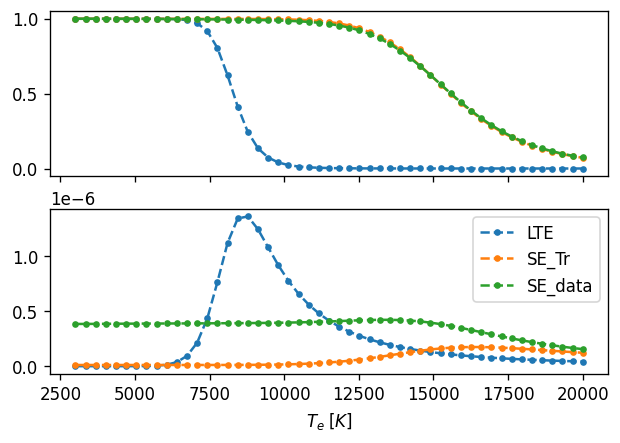

In [22]:
fig, axs = plt.subplots(2,1, figsize=(6,4), dpi=120, sharex = True)

ax = axs[0]
eta = etas["0"]
for i, name in enumerate(eta.keys()):
    ax.plot(Te[:], eta[name][:], '--o', markersize=3, label=name)

ax = axs[1]
eta = etas["1"]
for i, name in enumerate(eta.keys()):
    ax.plot(Te[:], eta[name][:], '--o', markersize=3, label=name)

ax.set_xlabel("$T_{e} \; [K]$")
#ax.set_ylabel("$ n_{H\, II} \; / \; n_{H} $")
ax.legend(loc="best")
#ax.set_yscale('log')
#ax.set_ylim(0, 2E-7)
#ax.set_title("ionization fraction v.s. eletron temperature")
plt.show()

## Ionization fraction v.s. Electron density

In [23]:

nNe = 51
Ne = np.logspace(8,15, nNe)
#Te = np.ones(nNe) * 8E3
Tr = 6E3
#Vt = np.ones(nNe) * 5E5
#Vd = np.ones(nNe) * 0E5

eta = {}
## radiation temperature
n_LTE    = np.ones((atom.nLevel, nNe))
n_SE_Tr  = np.ones((atom.nLevel, nNe))

for k in range(nNe):
    atmos = Atmosphere.Atmosphere0D(Nh=1.E10, Ne=Ne[k], Te=8.E3, Vd=0., Vt=5.E5, Tr=6.E3, use_Tr=True)
    SE_con, Rate_con = SELib.cal_SE_with_Ne_Te_(atom, atmos, wMesh,radiation, None)
    n_LTE[:,k] = SE_con.n_LTE[:]
    n_SE_Tr[:,k] = SE_con.n_SE[:]

eta["LTE"] = n_LTE[-1,:] / n_LTE[:,:].sum(axis=0)
eta["SE_Tr"] = n_SE_Tr[-1,:] / n_SE_Tr[:,:].sum(axis=0)

## background radiation
n_SE  = np.ones((atom.nLevel, nNe))
for k in range(nNe):
    atmos = Atmosphere.Atmosphere0D(Nh=1.E10, Ne=Ne[k], Te=8.E3, Vd=0., Vt=5.E5, Tr=6.E3, use_Tr=False)
    SE_con, Rate_con = SELib.cal_SE_with_Ne_Te_(atom, atmos, wMesh,radiation, None)
    n_SE[:,k] = SE_con.n_SE[:]

eta["SE_data"] = n_SE[-1,:] / n_SE[:,:].sum(axis=0)

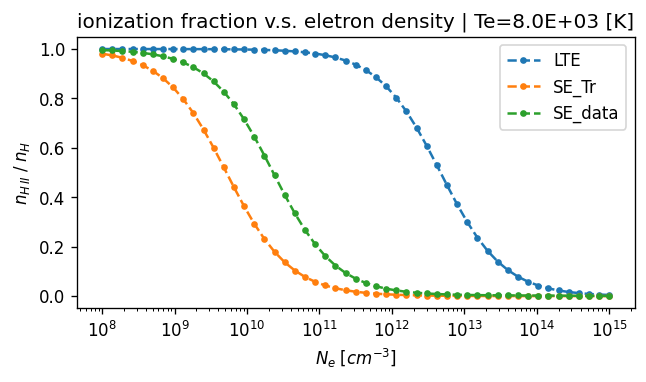

In [25]:
## plot
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=120)

for i, name in enumerate(eta.keys()):
    ax.plot(Ne[:], eta[name][:], '--o', markersize=3, label=name)

ax.set_xlabel("$N_{e} \; [cm^{-3}]$")
ax.set_ylabel("$ n_{H\, II} \; / \; n_{H} $")
ax.legend(loc="best")
ax.set_xscale('log')
ax.set_title(f"ionization fraction v.s. eletron density | Te={atmos.Te:1.1E} [K]")
plt.show()

In [76]:

nNe = 51
Ne = np.logspace(8,15, nNe)
#Te = np.ones(nNe) * 8E3
Tr = 6E3
#Vt = np.ones(nNe) * 5E5
#Vd = np.ones(nNe) * 0E5

eta = {}
## radiation temperature
n_LTE    = np.ones((atom.nLevel, nNe))
n_SE_Tr  = np.ones((atom.nLevel, nNe))

for k in range(nNe):
    atmos = Atmosphere.Atmosphere0D(Nh=1.E10, Ne=Ne[k], Te=8.E3, Vd=0., Vt=5.E5, Tr=6.E3, use_Tr=True)
    SE_con, Rate_con = SELib.cal_SE_with_Ne_Te_(atom, atmos, wMesh,radiation, None)
    n_LTE[:,k] = SE_con.n_LTE[:]
    n_SE_Tr[:,k] = SE_con.n_SE[:]

eta["LTE"] = n_LTE[-1,:] / n_LTE[:,:].sum(axis=0)
eta["SE_Tr"] = n_SE_Tr[-1,:] / n_SE_Tr[:,:].sum(axis=0)

## background radiation
n_SE  = np.ones((atom.nLevel, nNe))
for k in range(nNe):
    atmos = Atmosphere.Atmosphere0D(Nh=1.E10, Ne=Ne[k], Te=8.E3, Vd=0., Vt=5.E5, Tr=6.E3, use_Tr=False)
    SE_con, Rate_con = SELib.cal_SE_with_Ne_Te_(atom, atmos, wMesh,radiation, None)
    n_SE[:,k] = SE_con.n_SE[:]

eta["SE_data"] = n_SE[-1,:] / n_SE[:,:].sum(axis=0)

nH = Ne / ( 1.E-4 + n_SE[-1,:] )
#nH_neq3 = nH * n_SE[2,:] / n_SE[:,:].sum(axis=0)
#nH_neq1 = nH * n_SE[0,:] / n_SE[:,:].sum(axis=0)
#nH_neq2 = nH * n_SE[1,:] / n_SE[:,:].sum(axis=0)

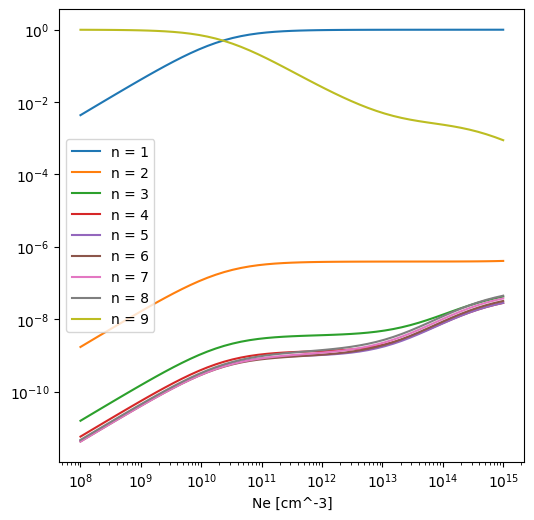

In [77]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=100)
for i in range(atom.nLevel):
    ax.plot( Ne, n_SE[i,:], label=f"n = {i+1}" )
#ax.plot( Ne, nH, label="nH density" )
#ax.plot( Ne, nH_neq3, label="n=3 density" )
#ax.plot( [1E8, 1E17], [1E8, 1E17] )
#ax.plot( [1E10, 1E13], [1E10, 1E16] )
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Ne [cm^-3]")
#ax.set_ylabel("nH [cm^-3]")
ax.legend()
plt.show()

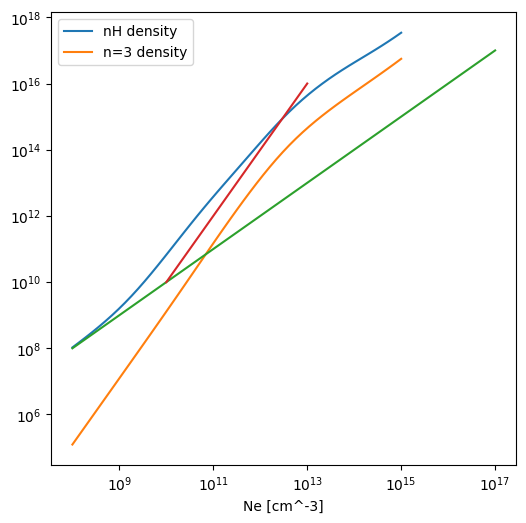

In [73]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=100)
ax.plot( Ne, nH, label="nH density" )
ax.plot( Ne, nH_neq3, label="n=3 density" )
ax.plot( [1E8, 1E17], [1E8, 1E17] )
ax.plot( [1E10, 1E13], [1E10, 1E16] )
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Ne [cm^-3]")
#ax.set_ylabel("nH [cm^-3]")
ax.legend()
plt.show()

In [30]:

nNe = 51
Ne = np.logspace(8,15, nNe)
Te = np.ones(nNe) * 8E3
Tr = 6E3
Vt = np.ones(nNe) * 5E5
Vd = np.ones(nNe) * 0E5

eta = {}
## radiation temperature
n_LTE , nj_by_ni_Line, nj_by_ni_Cont = SELib.ni_nj_LTE(atom, Te, Ne)

Rik, Rki_stim, Rki_spon = SELib.bf_R_rate(atom, Te, nj_by_ni_Cont, _Tr=Tr)
Bij_Jbar, Bji_Jbar = SELib.B_Jbar(atom, Te, _Tr=Tr)

##  ij : ij + ik
Cij = SELib.get_Cij(atom, Te)
Cji = Collision.Cij_to_Cji( Cij, np.append(nj_by_ni_Line,nj_by_ni_Cont, axis=0) )

n_SE = SELib.solve_SE(atom,
                     Ne, Cji, Cij,
                     Bji_Jbar, Bij_Jbar,
                     Rki_spon, Rki_stim, Rik)

eta["LTE"] = n_LTE[-1,:] / n_LTE[:,:].sum(axis=0)
eta["SE_Tr"] = n_SE[-1,:] / n_SE[:,:].sum(axis=0)

## background radiation
n_LTE , nj_by_ni_Line, nj_by_ni_Cont = SELib.ni_nj_LTE(atom, Te, Ne)

Rik, Rki_stim, Rki_spon = SELib.bf_R_rate(atom, Te, nj_by_ni_Cont, _backRad=backRad)
Bij_Jbar, Bji_Jbar = SELib.B_Jbar(atom, Te, _Vt=Vt, _Vd=Vd, _Ne=Ne, _backRad=backRad)

##  ij : ij + ik
Cij = SELib.get_Cij(atom, Te)
Cji = Collision.Cij_to_Cji( Cij, np.append(nj_by_ni_Line,nj_by_ni_Cont, axis=0) )

n_SE = SELib.solve_SE(atom,
                     Ne, Cji, Cij,
                     Bji_Jbar, Bij_Jbar,
                     Rki_spon, Rki_stim, Rik)

eta["SE_data"] = n_SE[-1,:] / n_SE[:,:].sum(axis=0)



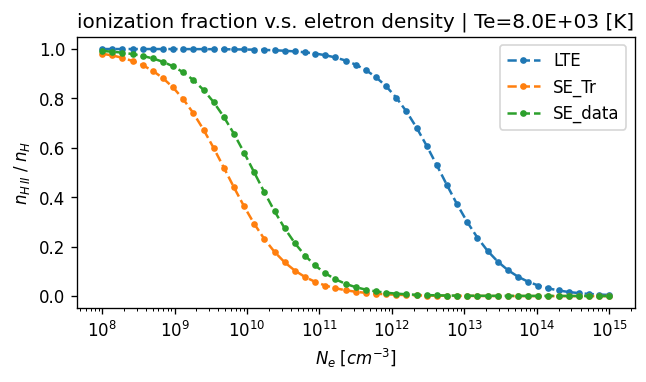

In [33]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=120)

for i, name in enumerate(eta.keys()):
    ax.plot(Ne[:], eta[name][:], '--o', markersize=3, label=name)

ax.set_xlabel("$N_{e} \; [cm^{-3}]$")
ax.set_ylabel("$ n_{H\, II} \; / \; n_{H} $")
ax.legend(loc="best")
ax.set_xscale('log')
ax.set_title(f"ionization fraction v.s. eletron density | Te={Te[0]:1.1E} [K]")
plt.show()

## ionization fraction ($T_{e},N_{e}$)


### case of radiation temperature


In [26]:
nTe = 61
Te = np.linspace(5E3, 2E4, nTe)
nNe = 61
Ne = np.logspace(8,14, nNe)
Tr = 6.E3
#Te2d, Ne2d = np.meshgrid(Te, Ne)


kLevel = -1

eta = {
    "Local Termal Equil.": np.zeros((nNe,nTe)),
    "Statistical Equil." : np.zeros((nNe,nTe)),
    "Coronal Equil." : np.zeros((nNe,nTe)),
}

n_LTE    = np.ones((atom.nLevel, nNe))
n_SE_Tr  = np.ones((atom.nLevel, nNe))

for ke in range(nNe):
    for kt in range(nTe):
        ## LTE and Statistical Equilibrium
        atmos = Atmosphere.Atmosphere0D(Nh=1.E12, Ne=Ne[ke], Te=Te[kt], Vd=0., Vt=5.E5, Tr=Tr, use_Tr=True)
        SE_con, Rate_con = SELib.cal_SE_with_Ne_Te_(atom, atmos, wMesh,radiation, None)

        eta["Local Termal Equil."][ke,kt] = SE_con.n_LTE[kLevel] / SE_con.n_LTE[:].sum()
        eta["Statistical Equil."][ke,kt]  = SE_con.n_SE[kLevel] / SE_con.n_SE[:].sum()

        ## `Tr=0, use_Tr=True` to shut down radiation --> Coronal Equilibrium
        atmos = Atmosphere.Atmosphere0D(Nh=1.E12, Ne=Ne[ke], Te=Te[kt], Vd=0., Vt=5.E5, Tr=0., use_Tr=True)
        SE_con, Rate_con = SELib.cal_SE_with_Ne_Te_(atom, atmos, wMesh,radiation, None)

        eta["Coronal Equil."][ke,kt] = SE_con.n_SE[kLevel] / SE_con.n_SE[:].sum()


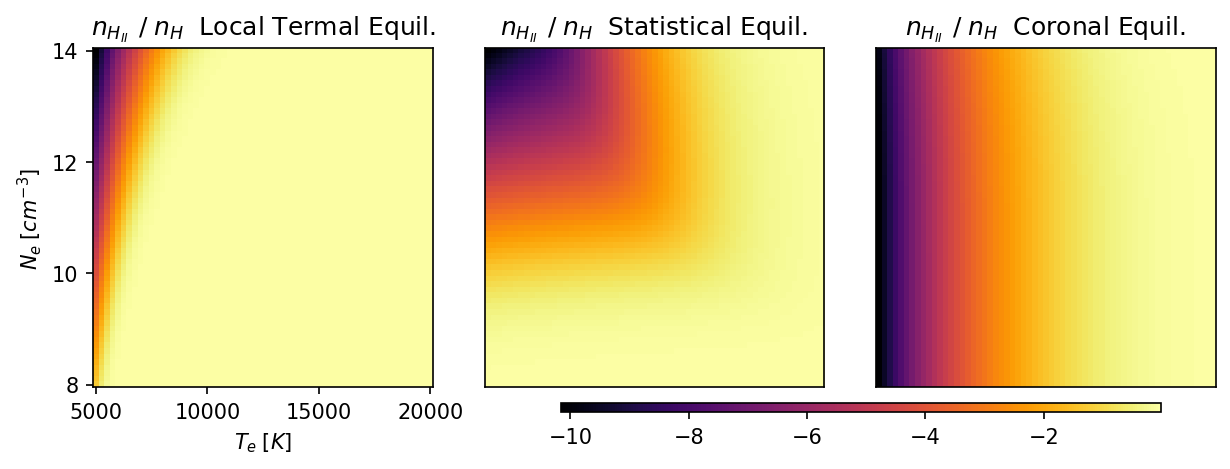

In [29]:
fig, axs = plt.subplots(1,3, figsize=(10,3), dpi=150)
plt.subplots_adjust(wspace=0.03)

for ax, name in zip( axs, eta.keys() ):
    im = ax.imshow(np.log10(eta[name][:,:]), cmap="inferno", origin="lower")

    Plotting.set_imshow_ticks_(ax, Te, axis='x',points=4, fmt='%1.0f',rot=0)
    Plotting.set_imshow_ticks_(ax, np.log10(Ne), axis='y',points=4, fmt='%1.0f',rot=0)
    ax.set_title("$ n_{H_{II}\,} \; / \; n_{H} $" + f"  {name}")

axs[0].set_ylabel("$N_{e} \; [cm^{-3}]$")
axs[0].set_xlabel("$T_{e} \; [K]$")
Plotting.remove_tick_ticklabel_(axs[1],axs[2], kind='xy')

cax = fig.add_axes([0.45,0.07,0.4,0.02])
fig.colorbar(im, cax=cax, orientation="horizontal")

plt.show()

### case of background radiation


In [30]:
nTe = 61
Te = np.linspace(5E3, 2E4, nTe)
nNe = 61
Ne = np.logspace(8,14, nNe)
Tr = 6.E3
#Te2d, Ne2d = np.meshgrid(Te, Ne)


kLevel = -1

eta = {
    "Local Termal Equil.": np.zeros((nNe,nTe)),
    "Statistical Equil." : np.zeros((nNe,nTe)),
    "Coronal Equil." : np.zeros((nNe,nTe)),
}

n_LTE    = np.ones((atom.nLevel, nNe))
n_SE_Tr  = np.ones((atom.nLevel, nNe))

for ke in range(nNe):
    for kt in range(nTe):
        ## LTE and Statistical Equilibrium
        atmos = Atmosphere.Atmosphere0D(Nh=1.E12, Ne=Ne[ke], Te=Te[kt], Vd=0., Vt=5.E5, Tr=6.E3, use_Tr=False)
        SE_con, Rate_con = SELib.cal_SE_with_Ne_Te_(atom, atmos, wMesh,radiation, None)

        eta["Local Termal Equil."][ke,kt] = SE_con.n_LTE[kLevel] / SE_con.n_LTE[:].sum()
        eta["Statistical Equil."][ke,kt]  = SE_con.n_SE[kLevel] / SE_con.n_SE[:].sum()

        ## `Tr=0, use_Tr=True` to shut down radiation --> Coronal Equilibrium
        atmos = Atmosphere.Atmosphere0D(Nh=1.E12, Ne=Ne[ke], Te=Te[kt], Vd=0., Vt=5.E5, Tr=0., use_Tr=True)
        SE_con, Rate_con = SELib.cal_SE_with_Ne_Te_(atom, atmos, wMesh,radiation, None)

        eta["Coronal Equil."][ke,kt] = SE_con.n_SE[kLevel] / SE_con.n_SE[:].sum()


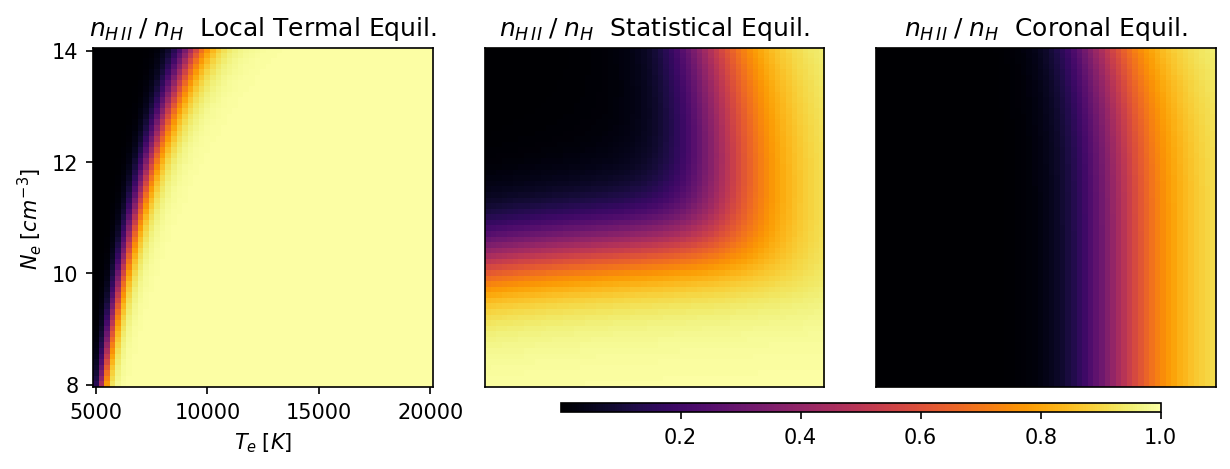

In [31]:
fig, axs = plt.subplots(1,3, figsize=(10,3), dpi=150)
plt.subplots_adjust(wspace=0.03)

for ax, name in zip( axs, eta.keys() ):
    im = ax.imshow(eta[name][:,:], cmap="inferno", origin="lower", vmin=1.E-9, vmax=1.)

    Plotting.set_imshow_ticks_(ax, Te, axis='x',points=4, fmt='%1.0f',rot=0)
    Plotting.set_imshow_ticks_(ax, np.log10(Ne), axis='y',points=4, fmt='%1.0f',rot=0)
    ax.set_title("$ n_{H\, II} \; / \; n_{H} $" + f"  {name}")

axs[0].set_ylabel("$N_{e} \; [cm^{-3}]$")
axs[0].set_xlabel("$T_{e} \; [K]$")
Plotting.remove_tick_ticklabel_(axs[1],axs[2], kind='xy')

cax = fig.add_axes([0.45,0.07,0.4,0.02])
fig.colorbar(im, cax=cax, orientation="horizontal")

plt.show()

## $N_{e}$ iteration, with QS background radiation

In [32]:
Te = 1.E4
#Ne = 1E11
Tr = 6.E3
Vd = 0.E5
Vt = 5.E5

Nh  = 1E12      # [cm^{-3}]

atmos = Atmosphere.Atmosphere0D(Nh=Nh, Ne=0., Te=Te, Vd=Vd, Vt=Vt, Tr=Tr, use_Tr=False)
SE_con, Rate_con = SELib.cal_SE_with_Nh_Te_(atom, atmos, wMesh,radiation, None)


print(f"Electron temperature  = {Te:.1E}")
print(f"Electron density      = {atmos.Ne:.1E}")
print('-'*35)
print("SE  :")
for v in SE_con.n_SE[:]:
    print(f"{v:.4E}",end="  ")
print(f"\nLTE :")
for v in SE_con.n_LTE[:]:
    print(f"{v:.4E}",end="  ")

Electron temperature  = 1.0E+04
Electron density      = 1.6E+11
-----------------------------------
SE  :
8.4416E-01  3.3450E-07  3.1010E-09  1.1349E-09  8.6830E-10  8.2319E-10  8.9060E-10  1.0464E-09  1.5584E-01  
LTE :
4.6413E-04  1.3450E-08  3.3810E-09  2.7911E-09  3.0577E-09  3.6308E-09  4.3993E-09  5.3283E-09  9.9954E-01  

### population v.s. Electron temperature

In [33]:
nTe = 51
Te_arr = np.linspace(3E3, 2E4, nTe)
Nh = 1E11               # [cm^{-3}]
Vd = 0E5 # [cm]
Vt = 5E5 # [cm]
Tr = 6E3
use_Tr = False


Ne  = 0.5 * Nh
Ne0 = 1E-4 * Nh # イオン化バルブ効果

pop_arr = {
    "LTE" : np.empty((atom.nLevel, nTe), dtype="float64"),
    "SE"  : np.empty((atom.nLevel, nTe), dtype="float64"),
}
Ne_arr = np.empty_like(Te_arr)

for k in range(nTe):
    Te = Te_arr[k]
    
    atmos = Atmosphere.Atmosphere0D(Nh=Nh, Ne=0., Te=Te, Vd=Vd, Vt=Vt, Tr=Tr, use_Tr=use_Tr)
    SE_con, Rate_con = SELib.cal_SE_with_Nh_Te_(atom, atmos, wMesh,radiation, None)
            
    Ne_arr[k] = atmos.Ne
    pop_arr["LTE"][:,k] = SE_con.n_LTE[:]
    pop_arr["SE"][:,k] = SE_con.n_SE[:]

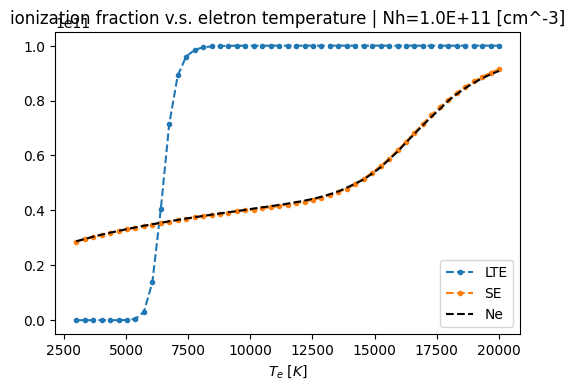

In [34]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=100, sharex = True)

kLevel = -1
for name, val in pop_arr.items():
    ax.plot(Te_arr[:], Nh*pop_arr[name][kLevel,:], '--o', markersize=3, label=name)

    
ax.set_xlabel("$T_{e} \; [K]$")
#ax.set_ylabel("$ n_{H\, II} \; / \; n_{H} $")
#ax.set_yscale('log')
#ax.set_ylim(0, 2E-7)
ax.set_title(f"ionization fraction v.s. eletron temperature | Nh={Nh:.1E} [cm^{-3}]")
#ax2 = ax.twinx()
ax.plot(Te_arr[:], Ne_arr[:], 'k--', label="Ne")
ax.legend(loc="lower right")
plt.show()

### population vs hydrogen density & electron temperature

In [35]:
nTe = 51
Te_arr = np.linspace(1E3, 2E4, nTe)
nNh = nTe
Nh_arr = np.logspace(8, 13, nNh)
Vd = 5E5 # [cm]
Vt = 5E5 # [cm]
#Tr = 6E3


pop_arr = {
    "LTE" : np.empty((atom.nLevel, nNh, nTe), dtype="float64"),
    "SE"  : np.empty((atom.nLevel, nNh, nTe), dtype="float64"),
}
Ne_arr = np.empty((nNh, nTe), dtype="float64")

for l in range(nNh):
    
    Nh = Nh_arr[l]
    
    #Ne  = 0.5 * Nh
    #Ne0 = 1E-4 * Nh # イオン化バルブ効果
    
    for k in range(nTe):
        Te = Te_arr[k]

        atmos = Atmosphere.Atmosphere0D(Nh=Nh, Ne=0., Te=Te, Vd=Vd, Vt=Vt, Tr=Tr, use_Tr=use_Tr)
        SE_con, Rate_con = SELib.cal_SE_with_Nh_Te_(atom, atmos, wMesh,radiation, None)

        Ne_arr[l,k] = atmos.Ne
        pop_arr["LTE"][:,l,k] = SE_con.n_LTE[:]
        pop_arr["SE"][:,l,k] = SE_con.n_SE[:]

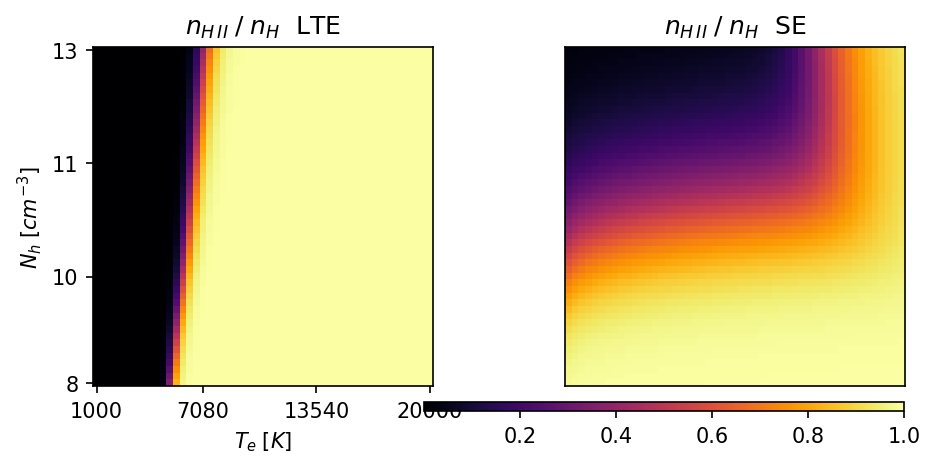

In [36]:
fig, axs = plt.subplots(1,2, figsize=(8,3), dpi=150)
plt.subplots_adjust(wspace=0.03)

for ax, name in zip( axs, pop_arr.keys() ):
    im = ax.imshow(pop_arr[name][-1,:,:], cmap="inferno", origin="lower", vmin=1.E-9, vmax=1.)

    Plotting.set_imshow_ticks_(ax, Te_arr, axis='x',points=4, fmt='%1.0f',rot=0)
    Plotting.set_imshow_ticks_(ax, np.log10(Nh_arr), axis='y',points=4, fmt='%1.0f',rot=0)
    ax.set_title("$ n_{H\, II} \; / \; n_{H} $" + f"  {name}")

axs[0].set_ylabel("$N_{h} \; [cm^{-3}]$")
axs[0].set_xlabel("$T_{e} \; [K]$")
Plotting.remove_tick_ticklabel_(axs[1], kind='xy')

cax = fig.add_axes([0.45,0.07,0.4,0.02])
fig.colorbar(im, cax=cax, orientation="horizontal")

plt.show()

## Line intensity ratio

In [38]:
from spectra_src.Function import SlabModel 

In [39]:
Te = 1.E4
#Ne = 1E11
Tr = 6.E3
Vd = 0.E5
Vt = 5.E5

Nh  = 1E12      # [cm^{-3}]

depth = 1.E3 * 1.E5 # 1000 [km]

atmos = Atmosphere.Atmosphere0D(Nh=Nh, Ne=0., Te=Te, Vd=Vd, Vt=Vt, Tr=Tr, use_Tr=False)
SE_con, Rate_con = SELib.cal_SE_with_Nh_Te_(atom, atmos, wMesh,radiation, None)

Cloud_con = SlabModel.SE_to_slab_0D_(atom, atmos, SE_con, depth=depth)

print(f"{'WAVELENGTH [AA]'}  {'MAX TAU'}      {'INTEGRATED INTENSITY [erg/cm^2/Sr/s]'}")
for k in (7,8,9):
    print(f"{Cloud_con.w0[k]*1.E8:.2f}{' ':10s}{Cloud_con.tau_max[k]:.2E}{' ':5s}{Cloud_con.Ibar[k]:.2E}")

WAVELENGTH [AA]  MAX TAU      INTEGRATED INTENSITY [erg/cm^2/Sr/s]
6564.63          1.52E+01     4.36E+05
4862.70          2.11E+00     1.69E+05
4341.70          7.05E-01     6.35E+04


## LTE Comtinuum transitions


refer to `TransferBasic.ipynb`

---

## Grotrian Plots

solve statistical equilibrium

given $N_e$

In [6]:
Te = 1.E4
Ne = 1E11
Tr = 6.E3
Vd = 0.E5
Vt = 5.E5

Nh  = 1E12      # [cm^{-3}]

depth = 1.E3 * 1.E5 # 1000 [km]

atmos = Atmosphere.Atmosphere0D(Nh=Nh, Ne=Ne, Te=Te, Vd=Vd, Vt=Vt, Tr=Tr, use_Tr=False)
SE_con, Rate_con = SELib.cal_SE_with_Ne_Te_(atom, atmos, wMesh,radiation, None)

#--------------

ni_Line = SE_con.n_SE[ atom.Line["idxI"] ][:]
nj_Line = SE_con.n_SE[ atom.Line["idxJ"] ][:]
ni_Cont = SE_con.n_SE[ atom.Cont["idxI"] ][:]
nj_Cont = SE_con.n_SE[ atom.Cont["idxJ"] ][:]
ni = np.append( ni_Line, ni_Cont )
nj = np.append( nj_Line, nj_Cont )
#--------------
idxI = np.append( atom.Line["idxI"], atom.Cont["idxI"] )
idxJ = np.append( atom.Line["idxJ"], atom.Cont["idxJ"] )

#--------------
#Bji_Jbar = Bji_Jbar[:,0]
#Bij_Jbar = Bij_Jbar[:,0]
#Rki_stim = Rki_stim[:,0]
#Rki_spon = Rki_spon[:,0]
#Rik = Rik[:,0]
#Cji = Cji[:,0]
#Cij = Cij[:,0]



initilize `Grotrian` object

In [7]:
from spectra_src.Visual import Grotrian

In [42]:
path_dict["Grotrian"]

'/Users/liu/kouui/workspace/spectra/data/atom/H/H.Grotrian'

In [8]:
scaleFunc     = lambda x: x**(7)
scaleFunc_inv = lambda x : x**(1/7)
gro = Grotrian.Grotrian(atom, path_dict["Grotrian"], _scaleFunc=scaleFunc, _scaleFunc_inv=scaleFunc_inv, )

radiative transition net rate

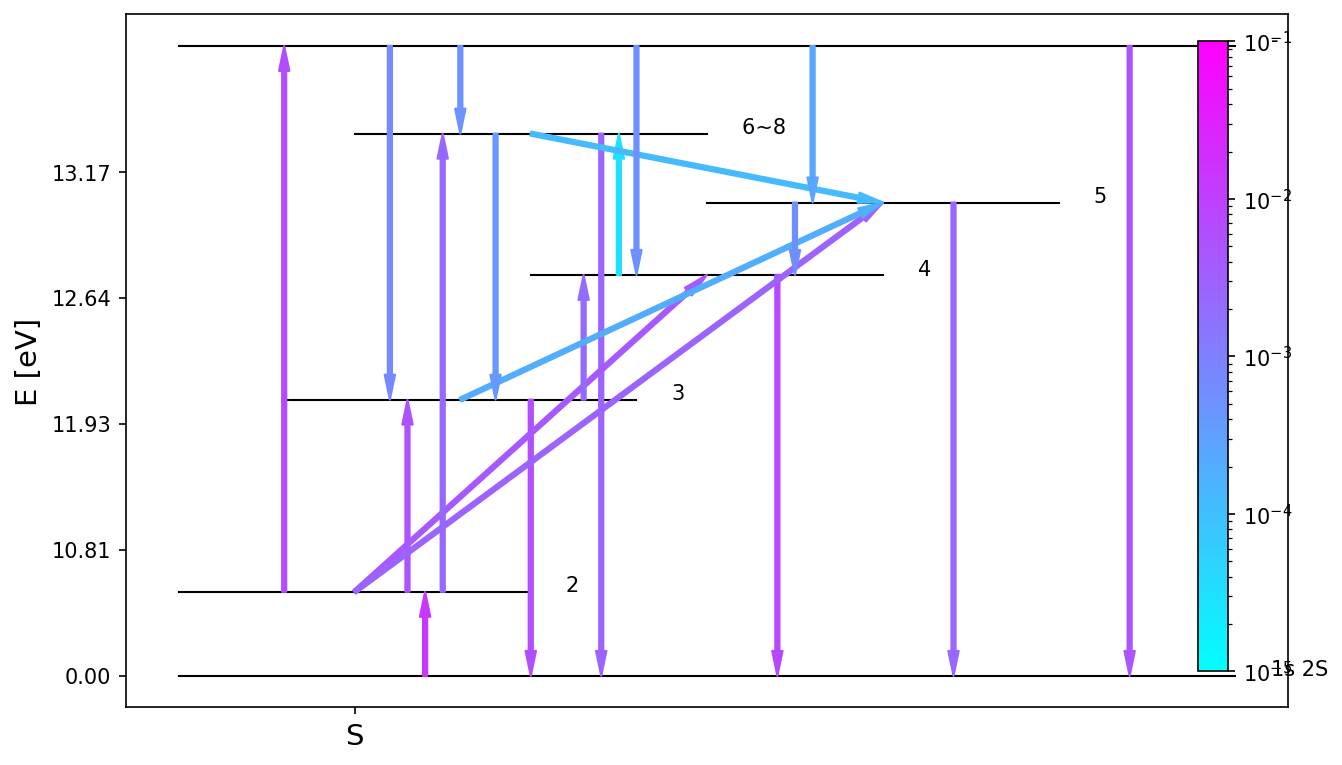

In [10]:
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)

cmap = plt.get_cmap('cool')
norm = LogNorm(1E-5, 1E-1, clip=True)


#--------------
#rate_rad = np.append( Bji_Jbar*nj_Line +
#                  atom.Line.AJI*nj_Line -
#                  Bij_Jbar*ni_Line,
#                  Rki_stim*nj_Cont +
#                  Rki_spon*nj_Cont -
#                  Rik*ni_Cont, axis=0 ).reshape(-1)
#rate_rad = np.append( Bij_Jbar*ni_Line*Nh,
#                  np.zeros_like(Rki_stim*nj_Cont), axis=0 ).reshape(-1)
rate_rad = - Rate_con.Rij * ni  + (Rate_con.Rji_stim + Rate_con.Rji_spon) * nj
#rate_rad[:] *= atmos.Nh
#--------------

gro.plot_transition_rate(_idxI=idxI,
                         _idxJ=idxJ,
                         _rate=rate_rad,
                         _direction="j->i",
                         _cmap=cmap, _norm=norm, _abserr=1E-5)
gro.add_colorbar(_cmap=cmap, _norm=norm)

collisional transition net rate

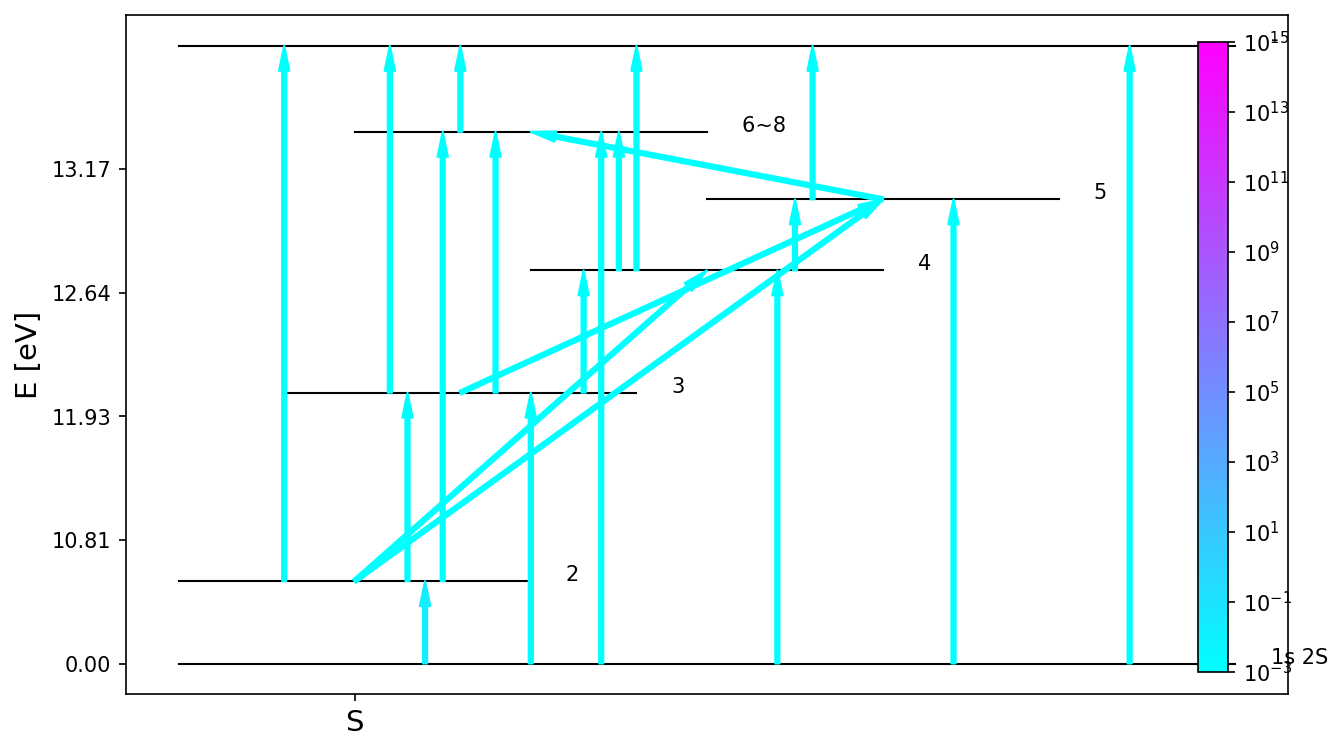

In [55]:
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)

cmap = plt.get_cmap('cool')
norm = LogNorm(1E-3, 1E15, clip=True)


#--------------
rate_col = (Rate_con.Cji_Ne * nj - Rate_con.Cij_Ne * ni) #* atmos.Nh  # [cm^{-3} s^{-1}]
#--------------


gro.plot_transition_rate(_idxI=idxI,
                         _idxJ=idxJ,
                         _rate=rate_col,
                         _direction="j->i",
                         _cmap=cmap, _norm=norm, _abserr=1E-5)
gro.add_colorbar(_cmap=cmap, _norm=norm)

radiative + collisional net rate

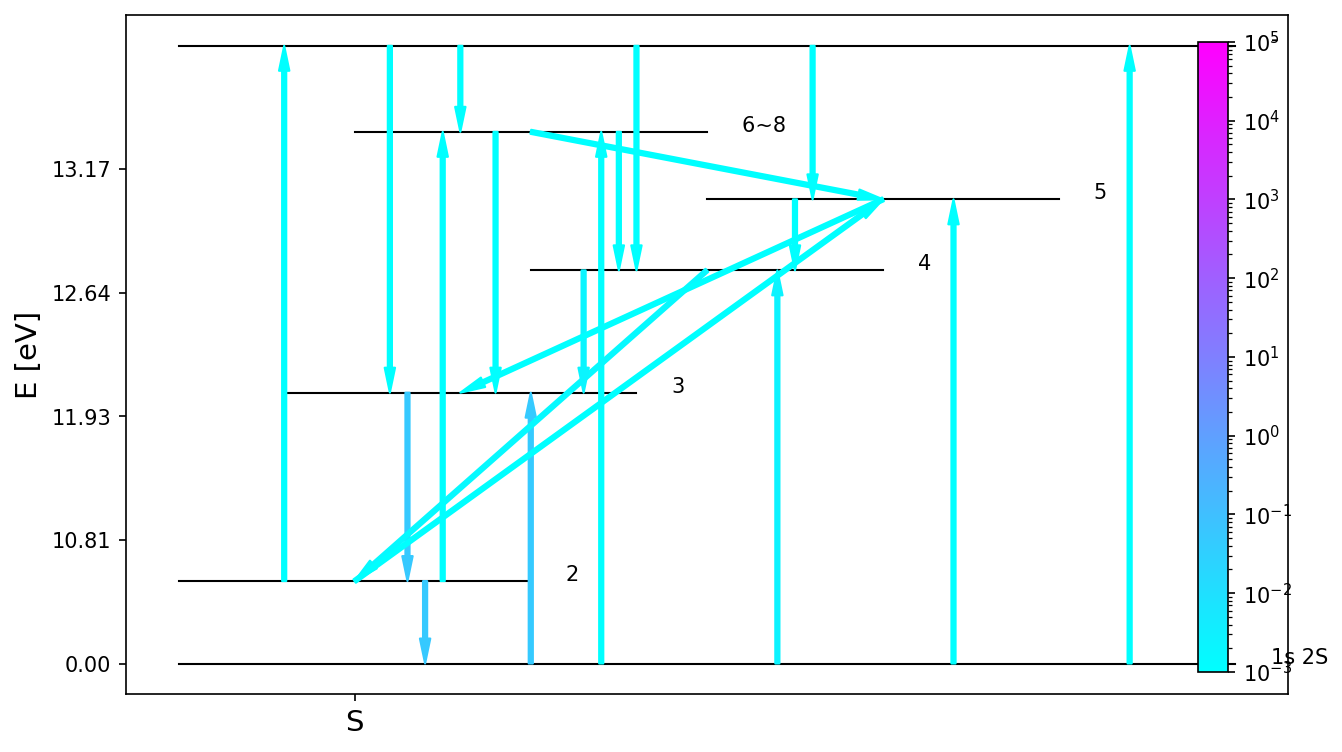

In [58]:
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)

cmap = plt.get_cmap('cool')
norm = LogNorm(1E-3, 1E5, clip=True)

#--------------
rate = rate_rad + rate_col
#--------------

gro.plot_transition_rate(_idxI=idxI,
                         _idxJ=idxJ,
                         _rate=rate,
                         _direction="j->i",
                         _cmap=cmap, _norm=norm, _abserr=1E-5)
gro.add_colorbar(_cmap=cmap, _norm=norm)

emmmmm....... collisional process is insignificant in Hydrogen atom !?

transition heat map

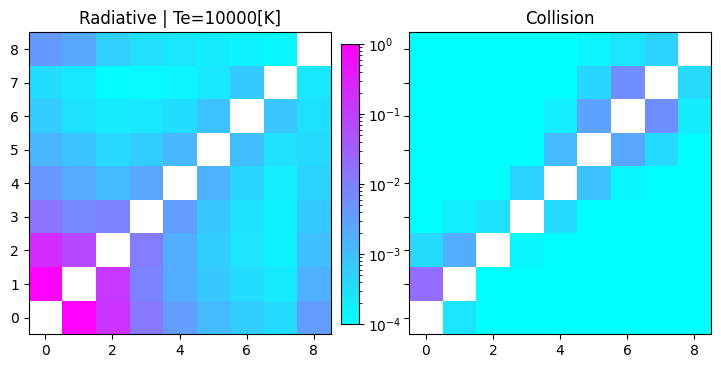

In [56]:
tran_mat = {
    "Radiative" : Rate_con.Rmat * SE_con.n_SE.reshape(1,-1),
    "Collision" : Rate_con.Cmat * SE_con.n_SE.reshape(1,-1),
}


fig, axs = plt.subplots(1,2, figsize=(9,4), dpi=100, sharey=True)
norm = LogNorm(1E-4, 1E-0, clip=True)

for ax, name in zip( axs, ("Radiative", "Collision") ):
    im = ax.imshow( tran_mat[name], origin="lower", cmap="cool", norm=norm )
    if name == "Radiative":
        ax.set_title(name+f" | Te={Te:.0f}[K]") 
    else:
        ax.set_title(name)

# colorbar
cax = fig.add_axes([0.48, 0.15, 0.02, 0.7])
fig.colorbar( im, cax=cax, orientation='vertical')

plt.show()

del ax, name, im

# [/s* cm^{-3}]


with animation

In [57]:
nTe = 35
Te_arr = np.linspace(3000., 20000., nTe)
Ne = 1E11
Tr = 6.E3
Vd = 0.E5
Vt = 5.E5

Nh  = 1E12      # [cm^{-3}]

#depth = 1.E3 * 1.E5 # 1000 [km]

tran_mat = {
    "Radiative" : np.zeros( (nTe, atom.nLevel, atom.nLevel), dtype="float64"),
    "Collision" : np.zeros( (nTe, atom.nLevel, atom.nLevel), dtype="float64"),
}
for kTe in range(nTe):
    Te = Te_arr[kTe]
    atmos = Atmosphere.Atmosphere0D(Nh=Nh, Ne=Ne, Te=Te, Vd=Vd, Vt=Vt, Tr=Tr, use_Tr=False)
    SE_con, Rate_con = SELib.cal_SE_with_Ne_Te_(atom, atmos, wMesh,radiation, None)
    
    tran_mat["Radiative"][kTe,:,:] = Rate_con.Rmat * SE_con.n_SE.reshape(1,-1)
    tran_mat["Collision"][kTe,:,:] = Rate_con.Cmat * SE_con.n_SE.reshape(1,-1)

##--------------
#ni_Line = SE_con.n_SE[ atom.Line["idxI"] ][:]
#nj_Line = SE_con.n_SE[ atom.Line["idxJ"] ][:]
#ni_Cont = SE_con.n_SE[ atom.Cont["idxI"] ][:]
#nj_Cont = SE_con.n_SE[ atom.Cont["idxJ"] ][:]
#ni = np.append( ni_Line, ni_Cont )
#nj = np.append( nj_Line, nj_Cont )
##--------------
#idxI = np.append( atom.Line["idxI"], atom.Cont["idxI"] )
#idxJ = np.append( atom.Line["idxJ"], atom.Cont["idxJ"] )

In [58]:
#from matplotlib import animation
#from IPython.display import display, HTML

fig, axs = plt.subplots(1,2, figsize=(9,4), dpi=120, sharey=True)
fig.patch.set_facecolor("white")
norm = LogNorm(1E-4, 1E-0, clip=True)

ims = {}
for ax, name in zip( axs, ("Radiative", "Collision") ):
    ims[name] = ax.imshow( tran_mat[name][0,:,:],origin="lower", cmap="cool", norm=norm )
    ax.set_title(name)

# colorbar
cax = fig.add_axes([0.48, 0.15, 0.02, 0.7])
fig.colorbar( ims["Radiative"], cax=cax, orientation='vertical')

# make folder to save png figures
folder = os.path.join( CFG._ROOT_DIR, f"notebooks/StatisticalEquilibrium/plots")
if not os.path.exists(folder):
    os.mkdir(folder)


for i in range(nTe):
    for ax, name in zip( axs, ("Radiative", "Collision") ):
        #ax.clear()
        _ = ax.imshow( tran_mat[name][i,:,:], origin="lower", cmap="cool", norm=norm )
        if name == "Radiative":
            ax.set_title(name+f" | Te={Te_arr[i]:.0f}[K]") 
        else:
            ax.set_title(name)
    fname = os.path.join( folder, f"{i+1}.png" )
    fig.savefig(fname, dpi=120)

plt.close()
del ax, name, fname, cax, folder

#def _animate_radiative(_i):
#    _name = "Radiative"
#    ims[_name].set_array( tran_mat[_name][_i,:,:] )
#    return (ims[_name],)
#
#def _animate_collision(_i):
#    _name = "Collision"
#    ims[_name].set_array( tran_mat[_name][_i,:,:] )
#    return (ims[_name],)
#
#def _animate_all(_i):
#    return _animate_radiative(_i) + _animate_collision(_i)
#
##animALL = animation.FuncAnimation(fig, updateALL, interval = 20, blit = True)
#anim = animation.FuncAnimation(fig, _animate_all, frames=nTe, interval=20, repeat_delay=1,#repeat=True)
#
#display(HTML(anim.to_html5_video()))
#plt.close()
##plt.show()

